# Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
import csv

#  Feature Selection

In [2]:
def train_test_split(data_set, test_ratio, seed):

    df = pd.DataFrame(data_set)
    df = pd.get_dummies(data=df, columns=['Orientation', 'Glazing Area Distribution'])
    train_set = df.sample(frac=test_ratio, random_state=seed)
    test_set = df.drop(train_set.index)
    return np.array(train_set), np.array(test_set)


def select_feat(train_data, test_data, select_all=True):

    y_train, y_test = train_data[:,6], test_data[:,6]
    # raw_x_train, raw_x_test = np.delete(train_data, [5,6,7], 1), np.delete(test_data, [5,6,7], 1)
    raw_x_train, raw_x_test = np.delete(train_data, [5,6], 1), np.delete(test_data, [5,6], 1)  # cooling load

    if select_all:
        feat_idx = list(range(raw_x_train.shape[1]))
    else:
        feat_idx = [0,1,2,3,4]
        
    return raw_x_train[:,feat_idx], raw_x_test[:,feat_idx], y_train, y_test


data = pd.read_csv('energy_efficiency_data.csv')
train_data, test_data = train_test_split(data, 0.75, 100)
x_train, x_test, y_train, y_test = select_feat(train_data, test_data, select_all=True)
x_train, x_test, y_train, y_test = x_train, x_test, y_train.reshape(y_train.shape[0],1), y_test.reshape(y_test.shape[0],1)

# pd.DataFrame(train_data).to_csv("train_data.csv")
# pd.DataFrame(x_test).to_csv("x_test.csv")
# pd.DataFrame(y_train).to_csv("y_train.csv")

print('train_data =', train_data.shape)
print('test_data =', test_data.shape)
print('x_train =', x_train.shape)
print('x_test =', x_test.shape)
print('y_train =', y_train.shape)
print('y_test =', y_test.shape)


train_data = (576, 18)
test_data = (192, 18)
x_train = (576, 16)
x_test = (192, 16)
y_train = (576, 1)
y_test = (192, 1)


# Useful Functions

In [3]:
def calc_rmse(y_true, y_pred):
    return np.square(np.subtract(y_true, y_pred)).mean() ** 0.5

def SSE(f, y):
    # return (1./len(f)) * np.sum((f - y)**2)
    return np.sum((f - y)**2)

# Regression

In [4]:
class RegressionThreeLayerNN(object):

    def __init__(self, input_size, hidden_size, output_size, std=1e-4):  

        self.params = {}
        self.params['W1'] = std *np.random.randn(input_size, hidden_size)  
        self.params['b1'] = np.zeros((1, hidden_size)) 
        self.params['W2'] = std * np.random.randn(hidden_size, int(hidden_size/2)) 
        self.params['b2'] = np.zeros((1, int(hidden_size/2)))
        self.params['W3'] = std * np.random.randn(int(hidden_size/2), output_size) 
        self.params['b3'] = np.zeros((1, output_size))



    def loss(self, X, y=None, reg=0.0):

        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        W3, b3 = self.params['W3'], self.params['b3']
        N, D = X.shape  

        # forward
        Z1 = np.dot(X, W1) + b1
        A1 = np.maximum(0, Z1)
        Z2 = np.dot(A1, W2) + b2
        A2 = np.maximum(0, Z2)
        Z3 = np.dot(A2, W3) + b3


        # Compute the loss
        loss = SSE(Z3, y)


        # backward
        grads = {}

        # dZ3 = (2./len(y)) * (Z3 - y)
        dZ3 = (2.) * (Z3 - y)
        grads['W3'] = np.dot(A2.T, dZ3)
        grads['b3'] = np.sum(dZ3, axis=0, keepdims=True)

        dA2 = np.dot(dZ3, W3.T)
        dA2[A2 <= 0] = 0

        dZ2 = dA2
        grads['W2'] = np.dot(A1.T, dZ2)
        grads['b2'] = np.sum(dZ2, axis=0, keepdims=True)
        
        dA1 = np.dot(dZ2, W2.T)
        dA1[A1 <= 0] = 0

        dZ1 = dA1
        grads['W1'] = np.dot(X.T, dZ1)
        grads['b1'] = np.sum(dZ1, axis=0, keepdims=True)

        return loss, grads


    def train(self, X, y, X_test, y_test,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=5e-6, num_iters=100000,
            batch_size=32, verbose=False):


        num_train = X.shape[0]
        iterations_per_epoch = math.floor(num_train / batch_size)

        # Use SGD to optimize the parameters in self.model
        loss_history = []
        epoch_loss_history = []


        for it in range(num_iters):

            X_batch = None
            y_batch = None

            indices = np.random.choice(a=num_train, size=batch_size, replace=True)
            X_batch = X[indices]
            y_batch = y[indices]


            # Compute loss and gradients using the current minibatch
            loss, grads = self.loss(X=X_batch, y=y_batch, reg=reg)
            loss_history.append(loss)


            # upgrades
            self.params['W1'] += -learning_rate * grads['W1']
            self.params['W2'] += -learning_rate * grads['W2']
            self.params['W3'] += -learning_rate * grads['W3']
            self.params['b1'] += -learning_rate * grads['b1']
            self.params['b2'] += -learning_rate * grads['b2']
            self.params['b3'] += -learning_rate * grads['b3']


            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))


            # Every epoch, check train and test accuracy and decay learning rate.
            if it % iterations_per_epoch == 0:

                # Check accuracy
                # train_acc = (self.predict(X_batch) == y_batch).mean()
                # val_acc = (self.predict(X_val) == y_val).mean()
                # train_acc_history.append(train_acc)
                # val_acc_history.append(val_acc)
                epoch_loss_history.append(loss)
                # print(epoch_loss)

                # Decay learning rate
                # learning_rate *= learning_rate_decay

        return {'loss_history': loss_history, 'epoch_loss_history': epoch_loss_history}


    def predict(self, X):

        Z1 = np.dot(X, self.params['W1']) + self.params['b1']
        A1 = np.maximum(0, Z1)
        Z2 = np.dot(A1, self.params['W2']) + self.params['b2']
        A2 = np.maximum(0, Z2)
        Z3 = np.dot(A2, self.params['W3']) + self.params['b3']
        
        return Z3

In [5]:
nn = RegressionThreeLayerNN(input_size=16, hidden_size=80, output_size=1)

# Train the network
result = nn.train(x_train, y_train, x_test, y_test,
                  num_iters=30000, batch_size=100,
                  learning_rate=1e-6, learning_rate_decay=0.95,
                  reg=0, verbose=True)

iteration 0 / 30000: loss 61983.777458
iteration 100 / 30000: loss 54369.306764
iteration 200 / 30000: loss 59450.707339
iteration 300 / 30000: loss 59493.102962
iteration 400 / 30000: loss 46512.775674
iteration 500 / 30000: loss 52313.734171
iteration 600 / 30000: loss 11499.618987
iteration 700 / 30000: loss 10954.507763
iteration 800 / 30000: loss 5233.036106
iteration 900 / 30000: loss 3496.633825
iteration 1000 / 30000: loss 11638.460911
iteration 1100 / 30000: loss 9527.242236
iteration 1200 / 30000: loss 4755.102758
iteration 1300 / 30000: loss 4817.209090
iteration 1400 / 30000: loss 4340.341927
iteration 1500 / 30000: loss 16862.488369
iteration 1600 / 30000: loss 2890.188331
iteration 1700 / 30000: loss 2830.629024
iteration 1800 / 30000: loss 1992.399482
iteration 1900 / 30000: loss 3818.387952
iteration 2000 / 30000: loss 6153.496934
iteration 2100 / 30000: loss 2208.351361
iteration 2200 / 30000: loss 4578.903508
iteration 2300 / 30000: loss 3370.692063
iteration 2400 / 3

Text(0, 0.5, 'loss')

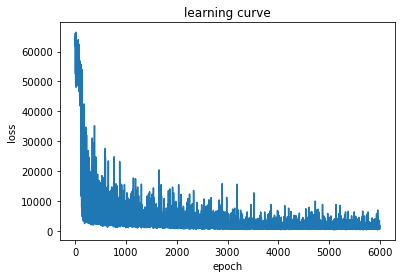

In [6]:
# Plot the training curve
plt.plot(result['epoch_loss_history'])
plt.title('learning curve')
plt.xlabel('epoch')
plt.ylabel('loss')

In [7]:
train_rmse = calc_rmse(y_true=y_train, y_pred=nn.predict(x_train))
print('train rmse: ', train_rmse)

# Predict on the test set
test_rmse = calc_rmse(y_true=y_test, y_pred=nn.predict(x_test))
print('test rmse: ', test_rmse)

train rmse:  2.3736009118807635
test rmse:  2.585218744603338


Text(0, 0.5, 'heating load')

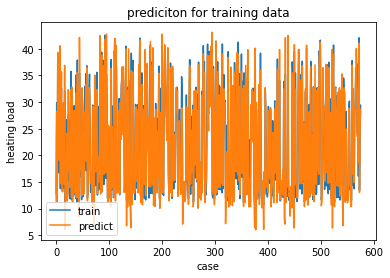

In [8]:
# plot training data
plt.plot(range(0,len(nn.predict(x_train))), nn.predict(x_train), label='train')
plt.plot(range(0,len(y_train)), y_train, label='predict')
plt.legend()
plt.title('prediciton for training data')
plt.xlabel('case')
plt.ylabel('heating load')

Text(0, 0.5, 'heating load')

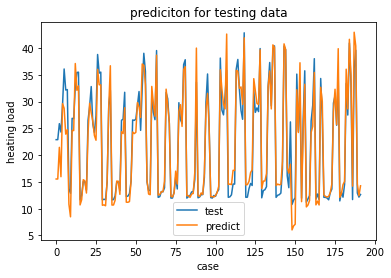

In [9]:
# plot testing data
plt.plot(range(0,len(nn.predict(x_test))), nn.predict(x_test), label='test')
plt.plot(range(0,len(y_test)), y_test, label='predict')
plt.legend()
plt.title('prediciton for testing data')
plt.xlabel('case')
plt.ylabel('heating load')